<a href="https://colab.research.google.com/github/Eran-BA/My-Projects/blob/master/Predicting%20clicks%20for%20adds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Clicks project**

*made by Eran Ben Artzy!*

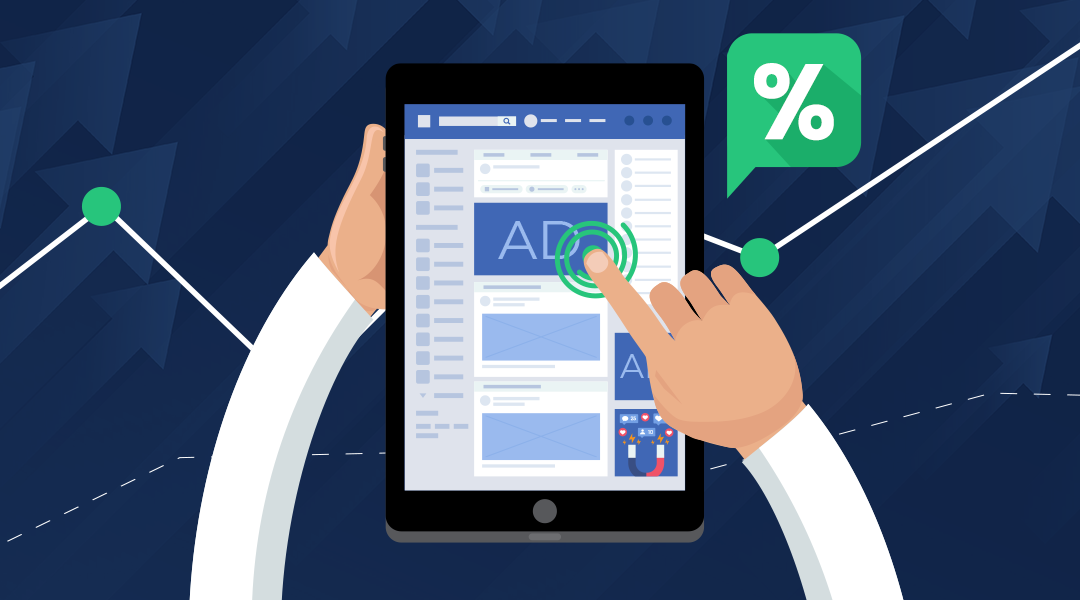

### KDD stages:
The KDD (Knowledge Discovery in Databases) stages will occur according to the following figure




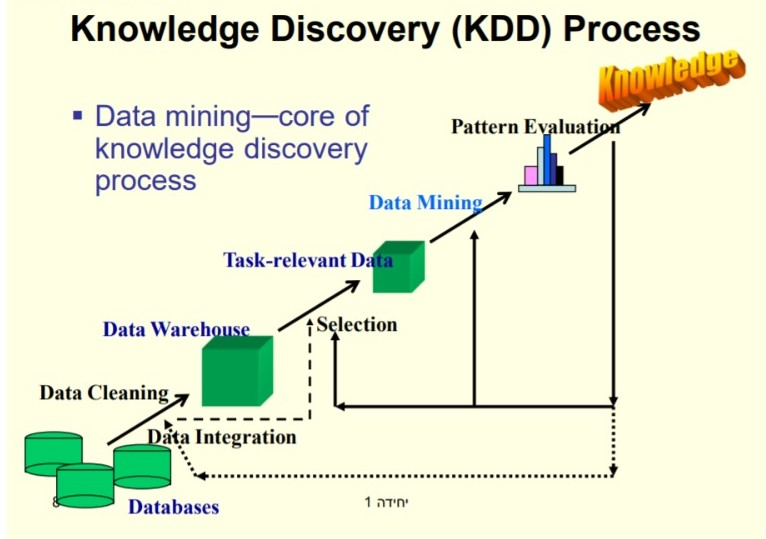

#Installations


In [1]:
!pip install TPOT

In [2]:
!pip3 install catboost

#Imports

Here we listed the main libraries used:


*   Numpy: Standard library for math operations on arrays
*   Pandas: Used to manipulate data inside dataframes and for basic computations
*   Sklearn: Used to apply different ML algorithms/models to the data
*   Matplotlib: Plot visualizations
*   Seaborn: Built on top of pyplot for nicer visualizations and easier plotting
*   Keras: Deep learning API written in Python, running on top of the machine learning platform TensorFlow allowing fast experimentation.
*   TPOT: AutoML library in python that optimizes ML pipelines using genetic programming.

*   SMOTE: Oversampling library that generates synthetic samples from the minority class.
It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

In [3]:
import warnings
def ignore_warn(*args,**kwargs):
  pass
warnings.warn = ignore_warn #ignore annoying warning from sklearn and seaborn 

In [4]:
# General
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter

# Debug
import pdb

# Plots 
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Scikit-Learn
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold,  train_test_split

# Imbalanced dataset
from imblearn.over_sampling import SMOTE

# Deep Learning
from keras import callbacks
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Auto ML
from tpot import TPOTClassifier

In [5]:
random_state = 42

In [6]:
df = pd.read_csv('Junior_DS_home-exercise_raw-data_2021.csv')

#Dataset

In [7]:
df.head()

,dt,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,ip_md5,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,2021-08-21,2,a5c1c94f6947bf7e9c1296061681f85e,0a4503d9a7996465ea226090ee7f3d2c,989fcad1435fb3a9130e7258265ab072,4418f45c75058a984aa1e9e55cdcbd7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,6d3f023811729eb62a548d91cb5de4c6,Honolulu,HI,2,728,90,1.0,0.013215,0.91,-1.0,0
1,2021-08-21,2,30d99b1e89be2a4f90c24df7652df5c8,b6f4b5808bf0ae55937d6a1c2bcf2e57,231f9d80be35bde77f5575f5bd3bef42,ddab5f19c67abff7b9664abcb3011839,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,a6c4374269e9ba4cf8377782ff452662,Tolleson,AZ,2,336,280,1.0,0.005450,0.61,1.0,0
2,2021-08-21,1,9b5187c93acaac0cb12475838c1a3888,37f07b1cc99272a163c7ae7ed95bcdfd,12110cb0c2d004614c3b31ce96254e3a,cc4f21a9f5f8ee2ff4053a9eb3221846,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,7cc8094f4469df7e12c0c60470e37f78,Arlington,TX,2,200,200,3.0,0.001672,0.56,-1.0,0
3,2021-08-21,1,89ba233487c434af8212fd3c89550c28,6839e98f304f1380ac001475ab0c7f30,7556f889d444a854a09639e3a38b50e3,b76eb71327ba080ed8fffacf1386c835,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,80648b01aad3abb46f06c88b47071989,NaN,MN,1,468,60,3.0,0.000585,0.43,-1.0,0
4,2021-08-21,1,d9741e0c9d1029615161d7cf14987bd3,8ac1d8fd1a6d8ef055ac7afc96d63902,91d201dbde18cc37b505d5100c96102d,74add3c7d6dab3a1b6a82919192b2f1d,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,0969dc27996adb403816d85a91958642,Tucson,AZ,1,300,250,3.0,0.001885,0.71,-1.0,0


In [8]:
df.dtypes

dt                   object
hr                    int64
publisher_id_md5     object
tag_id_md5           object
webpage_md5          object
domain_md5           object
user_agent           object
os                   object
browser              object
ip_md5               object
city                 object
state                object
auction_type          int64
banner_width          int64
banner_height         int64
banner_position     float64
ctr                 float64
viewability         float64
session_depth       float64
clicks                int64
dtype: object

#EDA

checking unique values for each column

In [9]:
for col in df:
  print(f'number of unique values of {col}:', df[col].nunique())

number of unique values of dt: 21
number of unique values of hr: 24
number of unique values of publisher_id_md5: 1196
number of unique values of tag_id_md5: 2244
number of unique values of webpage_md5: 17451
number of unique values of domain_md5: 2774
number of unique values of user_agent: 843
number of unique values of os: 9
number of unique values of browser: 60
number of unique values of ip_md5: 32441
number of unique values of city: 4590
number of unique values of state: 51
number of unique values of auction_type: 2
number of unique values of banner_width: 7
number of unique values of banner_height: 6
number of unique values of banner_position: 4
number of unique values of ctr: 10745
number of unique values of viewability: 72
number of unique values of session_depth: 127
number of unique values of clicks: 2


lets explore more the object variables

In [10]:
object_variables = ['publisher_id_md5', 'tag_id_md5', 'webpage_md5','domain_md5','user_agent','os','browser','ip_md5','city','state']  
df[object_variables].describe(include=['O'])  

,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,ip_md5,city,state
count,36353,36353,36321,36321,36353,36353,36353,36353,31099,36344
unique,1196,2244,17451,2774,843,9,60,32441,4590,51
top,d9741e0c9d1029615161d7cf14987bd3,128f21d32a90ff976102ecc7a3a4d804,b8d8ec496993ee59d1794416664b1718,91f6153240139a3b9ba22732798a2842,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,CHROME92,d89174994d3d0add0349b48679ce8bde,Chicago,TX
freq,1966,692,467,1416,5616,21815,11689,32,409,3594


As we can see from the table above that almost all the values in column "ip_md5" is unique, while the "publisher" column for example is not at all. There are too many unique elements within the ip_column and it is generally difficult to perform a prediction without the existence of a data pattern. Because of that, it will be omitted from further analysis. and we can assume that there aren't element of Time Series for infividual user. because each user is shown once.

In [11]:

df = df.drop(['ip_md5'], axis=1)

##Note: Time interval is only in one month, so we will omit month and year, and will stay only with day number

In [12]:
df['dt'] = pd.to_datetime(df['dt'])
df.insert(0, 'Day of month', df['dt'].dt.day)
df = df.drop(['dt'], axis=1)

In [13]:
df.head()

,Day of month,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,21,2,a5c1c94f6947bf7e9c1296061681f85e,0a4503d9a7996465ea226090ee7f3d2c,989fcad1435fb3a9130e7258265ab072,4418f45c75058a984aa1e9e55cdcbd7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Honolulu,HI,2,728,90,1.0,0.013215,0.91,-1.0,0
1,21,2,30d99b1e89be2a4f90c24df7652df5c8,b6f4b5808bf0ae55937d6a1c2bcf2e57,231f9d80be35bde77f5575f5bd3bef42,ddab5f19c67abff7b9664abcb3011839,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,Tolleson,AZ,2,336,280,1.0,0.005450,0.61,1.0,0
2,21,1,9b5187c93acaac0cb12475838c1a3888,37f07b1cc99272a163c7ae7ed95bcdfd,12110cb0c2d004614c3b31ce96254e3a,cc4f21a9f5f8ee2ff4053a9eb3221846,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Arlington,TX,2,200,200,3.0,0.001672,0.56,-1.0,0
3,21,1,89ba233487c434af8212fd3c89550c28,6839e98f304f1380ac001475ab0c7f30,7556f889d444a854a09639e3a38b50e3,b76eb71327ba080ed8fffacf1386c835,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,NaN,MN,1,468,60,3.0,0.000585,0.43,-1.0,0
4,21,1,d9741e0c9d1029615161d7cf14987bd3,8ac1d8fd1a6d8ef055ac7afc96d63902,91d201dbde18cc37b505d5100c96102d,74add3c7d6dab3a1b6a82919192b2f1d,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Tucson,AZ,1,300,250,3.0,0.001885,0.71,-1.0,0


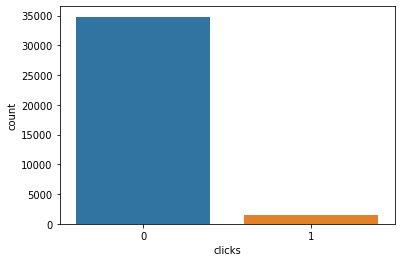

In [14]:
sns.countplot(x='clicks',data=df)

In [15]:
imp= df.groupby(['hr', 'clicks']).size().unstack()

In [16]:
imp

clicks,0,1
hr,,
0,673,21
1,526,16
2,367,15
3,303,9
4,301,11
5,413,7
6,624,19
7,1067,39
8,1496,57


[]

<Figure size 432x288 with 0 Axes>

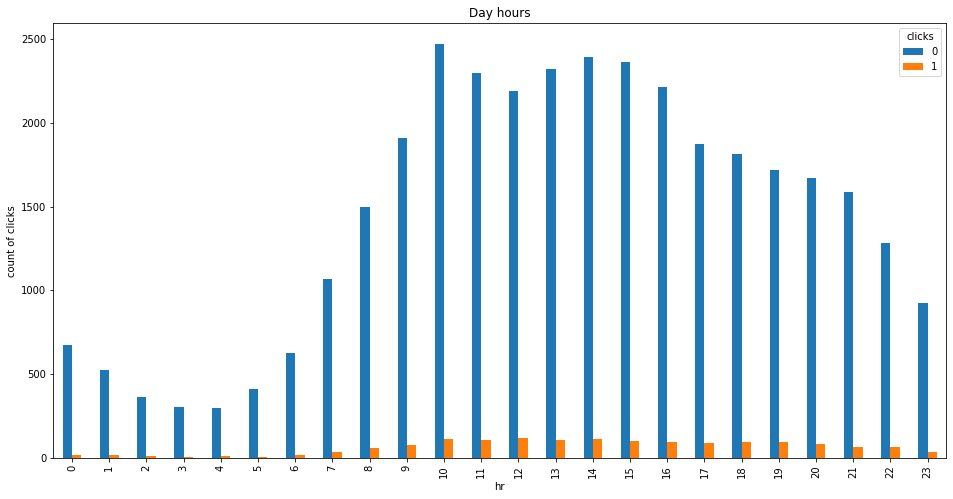

In [17]:
plt.figure()
imp.plot(kind='bar', title="Day hours", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

## <font color='black'>**Conclusion:  Here we can see the hourly impression and we can clearly see that the rate of clicks is very low as compared to non clicks when users are more active(between 10-22).**</font>

In [18]:
imp= df.groupby(['Day of month', 'clicks']).size().unstack()

[]

<Figure size 432x288 with 0 Axes>

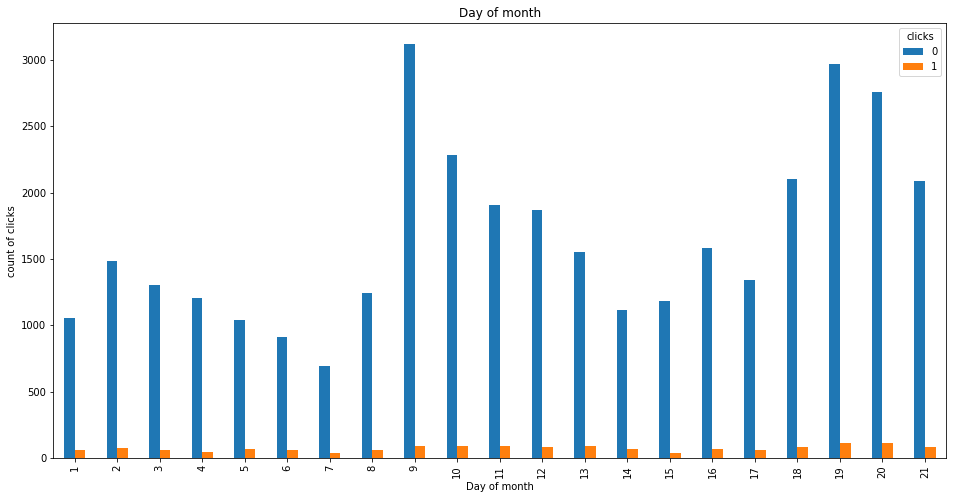

In [19]:
plt.figure()
imp.plot(kind='bar', title="Day of month", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

**Here we can see that there are days with a "Pick", the more the users are active, the more click perform**

IMPORTANT NOTE: As we see, I could bin the number of days for days of a week, and number of hours for am/pm , because we can see the pick times in each of the graphs. and ofcourse because time and hour are cyclic, and can teach us more.
I didnt had enough time for that, so I left as that, as it is.

In [20]:
df.groupby('banner_position')['clicks'].sum()

banner_position
1.0    828
3.0    714
5.0      0
6.0      4
Name: clicks, dtype: int64

In [21]:
df.banner_position.unique()

array([ 1.,  3.,  5.,  6., nan])




## <font color='black'>**Conclusion:  we can see that the banners positions in places 1 and 3 are most clickable, we can already think that this feature is a strong one..**</font>

In [22]:
df.groupby('browser')['clicks'].sum()

browser
CHROME70       1
CHROME71       0
CHROME72       1
CHROME73       0
CHROME74       0
CHROME75       5
CHROME76      22
CHROME77       4
CHROME78       0
CHROME79       0
CHROME80       2
CHROME81       1
CHROME83       1
CHROME84       5
CHROME85       9
CHROME86      11
CHROME87      14
CHROME88      27
CHROME89      22
CHROME90      36
CHROME91     284
CHROME92     618
EDGE81         0
EDGE82         0
EDGE83         0
EDGE84         1
EDGE85         1
EDGE86         0
EDGE87         0
EDGE88         0
EDGE89         4
EDGE90         1
EDGE91        10
EDGE92       208
FIREFOX66      0
FIREFOX67      0
FIREFOX68      2
FIREFOX69      0
FIREFOX70      0
FIREFOX71      0
FIREFOX72      1
FIREFOX73      0
FIREFOX74      1
FIREFOX75      0
FIREFOX76      0
FIREFOX77      2
FIREFOX78     16
FIREFOX79      0
FIREFOX80      0
FIREFOX81      0
FIREFOX82      0
FIREFOX83      1
FIREFOX84      1
FIREFOX85      2
FIREFOX86      0
FIREFOX87      0
FIREFOX88      1
FIREFOX89      6
FIREFO

probably, the most users exist in the latest version.

In [23]:
df.groupby('state')['clicks'].sum().sort_values(ascending=False)

state
TX    149
FL    126
NY     98
IL     86
NC     65
OH     64
GA     62
PA     54
VA     49
AZ     48
WA     46
MI     46
TN     41
IN     40
MN     37
NJ     37
MA     36
CO     35
OK     33
SC     31
MO     30
MD     28
AR     24
KS     21
AL     21
UT     20
WI     20
MS     20
IA     19
OR     19
LA     18
NV     16
CT     13
KY     12
WV     10
HI      8
WY      7
ME      7
NE      7
NM      7
ID      6
RI      5
ND      4
DC      4
NH      4
VT      4
SD      3
AK      3
MT      2
DE      1
CA      0
Name: clicks, dtype: int64

We can see here in which states most clicks occur , same as for cities as we will see immeditely.

In [24]:
df.groupby('city')['clicks'].sum().sort_values(ascending=False)

city
Chicago            22
New York           19
Dallas             16
Brooklyn           14
Houston            12
                   ..
North Lewisburg     0
North Las Vegas     0
North Kingstown     0
North Judson        0
Little Falls        0
Name: clicks, Length: 4590, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36353 entries, 0 to 36352
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Day of month      36353 non-null  int64  
 1   hr                36353 non-null  int64  
 2   publisher_id_md5  36353 non-null  object 
 3   tag_id_md5        36353 non-null  object 
 4   webpage_md5       36321 non-null  object 
 5   domain_md5        36321 non-null  object 
 6   user_agent        36353 non-null  object 
 7   os                36353 non-null  object 
 8   browser           36353 non-null  object 
 9   city              31099 non-null  object 
 10  state             36344 non-null  object 
 11  auction_type      36353 non-null  int64  
 12  banner_width      36353 non-null  int64  
 13  banner_height     36353 non-null  int64  
 14  banner_position   36350 non-null  float64
 15  ctr               36353 non-null  float64
 16  viewability       36353 non-null  float6

#Missing Values

In [26]:
df.isna().sum()

Day of month           0
hr                     0
publisher_id_md5       0
tag_id_md5             0
webpage_md5           32
domain_md5            32
user_agent             0
os                     0
browser                0
city                5254
state                  9
auction_type           0
banner_width           0
banner_height          0
banner_position        3
ctr                    0
viewability            0
session_depth          0
clicks                 0
dtype: int64

In [27]:
 df.dropna(inplace=True)

I didnt had enough time to explore Nans,install mean for each Nan, or predict the value with another model and so on, maybe I could transform them, but because I wanted to be able to solve the task given the times, I decided to get rid of them. 
we will see thats not big deal in terms of accuracy of the models.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31068 entries, 0 to 36352
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Day of month      31068 non-null  int64  
 1   hr                31068 non-null  int64  
 2   publisher_id_md5  31068 non-null  object 
 3   tag_id_md5        31068 non-null  object 
 4   webpage_md5       31068 non-null  object 
 5   domain_md5        31068 non-null  object 
 6   user_agent        31068 non-null  object 
 7   os                31068 non-null  object 
 8   browser           31068 non-null  object 
 9   city              31068 non-null  object 
 10  state             31068 non-null  object 
 11  auction_type      31068 non-null  int64  
 12  banner_width      31068 non-null  int64  
 13  banner_height     31068 non-null  int64  
 14  banner_position   31068 non-null  float64
 15  ctr               31068 non-null  float64
 16  viewability       31068 non-null  float6

In [29]:
df.isna().sum()

Day of month        0
hr                  0
publisher_id_md5    0
tag_id_md5          0
webpage_md5         0
domain_md5          0
user_agent          0
os                  0
browser             0
city                0
state               0
auction_type        0
banner_width        0
banner_height       0
banner_position     0
ctr                 0
viewability         0
session_depth       0
clicks              0
dtype: int64

In [30]:
df.describe()

,Day of month,hr,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
count,31068.000000,31068.000000,31068.000000,31068.000000,31068.000000,31068.000000,31068.000000,31068.000000,31068.000000,31068.000000
mean,12.248133,13.510622,1.789719,442.560706,249.278035,1.933501,-0.223112,0.676022,0.442674,0.042327
std,6.024088,5.422758,0.407514,223.119889,178.924454,1.069489,0.423905,0.267662,7.366234,0.201336
min,1.000000,0.000000,1.000000,120.000000,60.000000,1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,8.000000,10.000000,2.000000,300.000000,90.000000,1.000000,0.000000,0.520000,-1.000000,0.000000
50%,12.000000,14.000000,2.000000,336.000000,250.000000,1.000000,0.000963,0.725000,-1.000000,0.000000
75%,18.000000,18.000000,2.000000,728.000000,280.000000,3.000000,0.005199,0.870000,1.000000,0.000000
max,21.000000,23.000000,2.000000,728.000000,600.000000,6.000000,0.262326,1.000000,300.000000,1.000000


#Feature distributions

# skewness along the index axis


In [31]:
df.skew(axis = 0, skipna = True)

Day of month       -0.213687
hr                 -0.355892
auction_type       -1.421976
banner_width        0.298802
banner_height       0.975279
banner_position     0.601668
ctr                -1.284110
viewability        -2.760742
session_depth      15.761768
clicks              4.546652
dtype: float64

In [32]:
target = 'clicks'
numerical_features = ['banner_width','banner_height','ctr','viewability','session_depth']

#Outliers Detection
Tukey method is a single-step multiple comparison procedure and statistical test.

It can be used to find means that are significantly different from each other.

It's a statistical tool used to determine if the relationship between two sets of data is statistically significant – that is, whether there's a strong chance that an observed numerical change in one value is causally related to an observed change in another value.

In other words, the Tukey method is a way to test an experimental hypothesis.

In [33]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers  




In [34]:
rows_with_more_than_0_outlier = detect_outliers(df, 0 ,numerical_features)

In [35]:
rows_with_more_than_1_outlier = detect_outliers(df, 1 ,numerical_features)

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), we chose to manage them.

Tukey method detects ouliers by defining an interquartile range comprised between the 1st and the 3rd quartile of the distribution values (IQR).

An outlier is a row that have a feature value outside (IQR +- an outlier step).

In [36]:
df.loc[rows_with_more_than_0_outlier]

,Day of month,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
10,21,0,5fc291bff01b78c5f453a8e77cc2cfa3,9b1674c281218a5991163edaf8f127f4,01e599a13705d8199aef7aa5a5d4c04c,c7d37c0e21b8c99868344dfc78887318,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Junction City,OR,2,160,600,1.0,0.011989,0.91,-1.0,0
11,21,0,c2017bd8484d1bb6396b8e0dd2e6fa1d,0384b838e719b4170237c4918ac96b3b,e5a120f5aa3da562da7d1fded6a6048c,da1fdd00470294cf49a0790c7934d945,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Rainier,OR,2,120,600,1.0,0.008560,0.92,-1.0,0
13,21,5,37883f5499bda87ab6510ac03600b0d7,f208bcea6e6d81e935aef4f26f087885,c7d34e739173d22a63c2c5741830b755,8c67a5e874a7d134faddcce6876e63c5,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Muncie,IN,2,160,600,3.0,0.000412,0.87,-1.0,0
21,21,4,df07e2a2cf7134d81299d8c14834f018,42acfdc55e1193b977461be9af1cb0d8,164444f3294595f2e5f529d3764a23e1,4331d8ff9185c964811670e6e47c2c7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Mason,OH,2,160,600,1.0,0.011431,0.96,-1.0,0
43,21,0,1a110241d72b28a1d7be22d3fc9f2712,84422a2182d751042e5c5a3ae2e8352b,f2cf289c8d226f96207ebb98f1caef00,adc1cb7a6c231807480713da89957579,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:68.0) ...,WINDOWS_10,FIREFOX68,Boulder,CO,2,160,600,1.0,0.000287,0.54,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35609,2,13,6d1439a1eae6076c9ff8439e45a0a43f,07d1736fa8ca27dc8c633049e38e04e6,ff719ba1fb58ea2f3f49516fecc9013a,fb81e787ce1c58980998139c8d5f195b,Mozilla/5.0 (X11; CrOS aarch64 13816.82.0) App...,CHROME_OS,CHROME90,Washington,DC,2,336,280,1.0,0.000943,0.69,45.0,0
35614,5,21,9230e2c56b4c4ded140a6a4182cc319f,659c317d41bac956457d88e4b33ffd5d,88c5d658cbe7fb379d40b3658250d815,51bfad8686b239ee30e77dcd707f208e,Mozilla/5.0 (X11; CrOS x86_64 13904.97.0) Appl...,CHROME_OS,CHROME91,Tucson,AZ,2,728,90,3.0,0.001318,0.75,13.0,0
35752,3,22,9230e2c56b4c4ded140a6a4182cc319f,659c317d41bac956457d88e4b33ffd5d,cd8cecbfc2fb2049c65928988a3811a6,51bfad8686b239ee30e77dcd707f208e,Mozilla/5.0 (X11; CrOS x86_64 13904.97.0) Appl...,CHROME_OS,CHROME91,Ingleside,TX,2,728,90,1.0,0.000602,0.89,38.0,0
35835,2,14,bfeda872193199caaa9088632a7ad415,2375a8742b2684d9c69960e0bc8a3705,c00c0f7f815ec6ef17e9205f0d9d6f15,1218958219de1b5b28f18b1f2d4666f6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,MAC_OS_X,CHROME91,Columbus,GA,2,336,280,3.0,0.002587,0.32,6.0,0


In [37]:
#df.loc[rows_with_more_than_1_outlier]

In [38]:
df_outliers = df.copy()
df = df.drop(rows_with_more_than_0_outlier, axis=0).reset_index(drop=True)

In [39]:
df.describe()

,Day of month,hr,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
count,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000
mean,12.579069,13.422665,1.768026,492.766356,179.122311,1.941188,0.002667,0.688659,-0.503884,0.034029
std,6.059507,5.434862,0.422106,197.748779,90.397117,1.085829,0.003137,0.195812,0.922220,0.181309
min,1.000000,0.000000,1.000000,200.000000,60.000000,1.000000,0.000000,0.300000,-1.000000,0.000000
25%,9.000000,10.000000,2.000000,300.000000,90.000000,1.000000,0.000530,0.530000,-1.000000,0.000000
50%,12.000000,14.000000,2.000000,336.000000,250.000000,1.000000,0.001281,0.710000,-1.000000,0.000000
75%,19.000000,18.000000,2.000000,728.000000,280.000000,3.000000,0.003568,0.860000,-1.000000,0.000000
max,21.000000,23.000000,2.000000,728.000000,280.000000,6.000000,0.012975,1.000000,4.000000,1.000000


In [40]:
df.skew(axis = 0, skipna = True)

Day of month      -0.270844
hr                -0.343752
auction_type      -1.270107
banner_width       0.275575
banner_height     -0.064263
banner_position    0.669904
ctr                1.560785
viewability       -0.296811
session_depth      1.580457
clicks             5.140731
dtype: float64

we can see that the distribution of the label 'clicks' is very skewed, we will see that later in a plot.

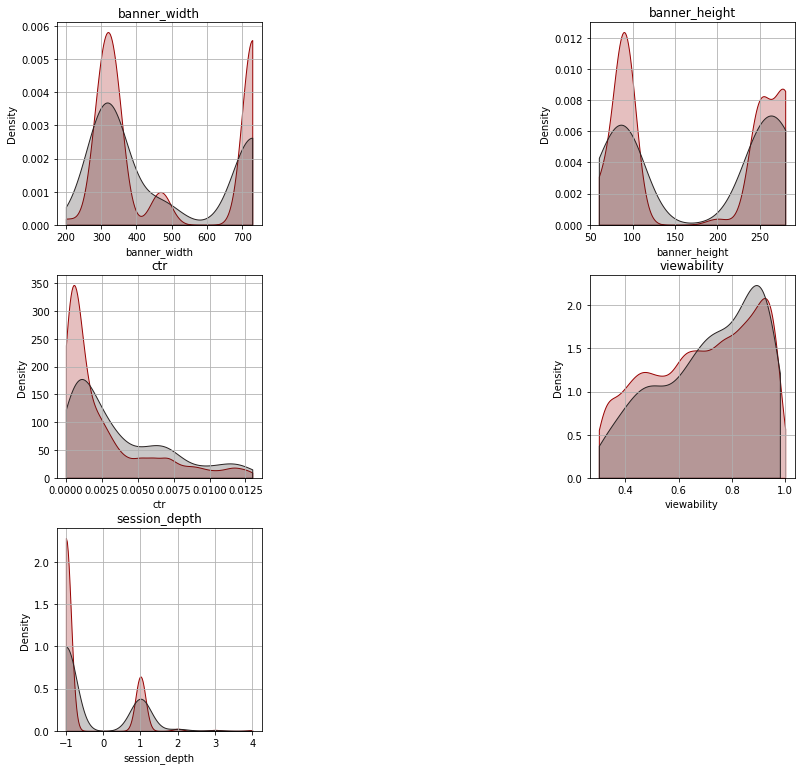

In [41]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df[target]==0, col], label="click", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df[target]==1, col], label="noclick",  color = "#292323", shade=True, kernel='gau', cut=0)

We can see that actully banner_width values are very Dichotomic, also Session_depth, and banner_height.
and ctr is a little "right -skewed", so we may consider to normalize it by applying a log, and consider session depth as a categorical feature. 
and also considering binning "banner height&weight"

In [42]:
categorical_features = ['Day of month','session_depth','hr','auction_type','banner_position']

We can see that banner position has noise in it, so we will remove the noise by casting to int.

In [43]:
df['banner_position'] =  df['banner_position'].astype(int)

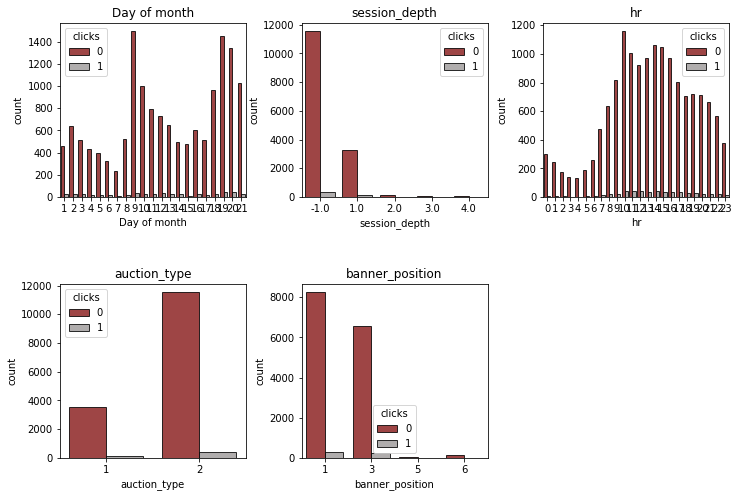

In [44]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue=target, palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

we can see from this charts , for example that the auction type, doesnt influencing so much on th enumber of clicks. because even though auction type is very big , it doesnt receive alot of clicks.
also , that there is a hours of pic with users, like around 10:00 - 12:00.
and so on. 

In [45]:
object_features = ["publisher_id_md5","tag_id_md5","webpage_md5","domain_md5","user_agent","os","browser"]


In [46]:
df_describe = df.describe()

In [47]:
df_outliers_describe = df_outliers.describe() 

In [48]:
def obj_clean(X,df_describe):

    def get_click_rate(x):
        temp = df[df[X.columns[0]] == x]
        res = round((temp.clicks.sum() / temp.clicks.count()),3)
        return res

    def get_type(V, str):
        very_high = df_describe.loc['mean','clicks'] + 0.04
        higher = df_describe.loc['mean','clicks'] + 0.02
        lower = df_describe.loc['mean','clicks'] - 0.02
        very_low = df_describe.loc['mean','clicks'] - 0.04

        vh_type = V[V[str] > very_high].index.tolist()
        hr_type = V[(V[str] > higher) & (V[str] < very_high)].index.tolist()
        vl_type = V[V[str] < very_low].index.tolist()
        lr_type = V[(V[str] < lower) & (V[str] > very_low)].index.tolist()

        return vh_type, hr_type, vl_type, lr_type

    def clean_function(x):
        while x in type_[0]:
            return 'very_high'
        while x in type_[1]:
            return 'higher'
        while x in type_[2]:
            return 'very_low'
        while x in type_[3]:
            return 'lower'
        return 'mid'
        
    print('Run: ', X.columns[0])
    fq = X[X.columns[0]].value_counts()
    if len(fq) > 1000:
        fq = fq[:1000]

    fq = pd.DataFrame(fq)
    fq['new_column'] = fq.index    

    fq['click_rate'] = fq.new_column.apply(get_click_rate)

    type_ = get_type(fq, 'click_rate')

    return X[X.columns[0]].apply(clean_function)



**lets make binning for the object features:**

In [49]:
for i in object_features:    
    df[[i]] = obj_clean(df[[i]],df_describe)

Run:  publisher_id_md5
Run:  tag_id_md5
Run:  webpage_md5
Run:  domain_md5
Run:  user_agent
Run:  os
Run:  browser


In [50]:
for i in object_features:    
    df_outliers[[i]] = obj_clean(df_outliers[[i]],df_outliers_describe)

Run:  publisher_id_md5
Run:  tag_id_md5
Run:  webpage_md5
Run:  domain_md5
Run:  user_agent
Run:  os
Run:  browser


In [51]:
df

,Day of month,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,21,2,lower,lower,lower,lower,higher,mid,mid,Tolleson,AZ,2,336,280,1,0.005450,0.61,1.0,0
1,21,1,mid,lower,lower,mid,mid,mid,mid,Arlington,TX,2,200,200,3,0.001672,0.56,-1.0,0
2,21,1,higher,very_high,very_high,very_high,mid,mid,mid,Tucson,AZ,1,300,250,3,0.001885,0.71,-1.0,0
3,21,1,very_high,very_high,mid,very_high,mid,mid,mid,East Orange,NJ,2,728,90,1,0.003074,0.55,-1.0,0
4,21,3,mid,lower,mid,lower,mid,mid,mid,Ashburn,VA,2,336,280,3,0.005167,0.74,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15570,3,16,lower,lower,lower,lower,mid,mid,mid,Verona,WI,2,728,90,1,0.000262,0.50,-1.0,0
15571,3,16,lower,lower,mid,lower,mid,mid,mid,Brandon,FL,2,336,280,1,0.003590,0.72,-1.0,0
15572,3,16,lower,lower,mid,lower,mid,mid,mid,Hilton Head Island,SC,2,336,280,1,0.000781,0.89,-1.0,0
15573,2,21,mid,mid,mid,mid,mid,mid,mid,Calumet City,IL,1,728,90,3,0.002101,0.46,-1.0,0


lets see the feature distribution accoarding to the binning we made, and acording to of the 'click' label.

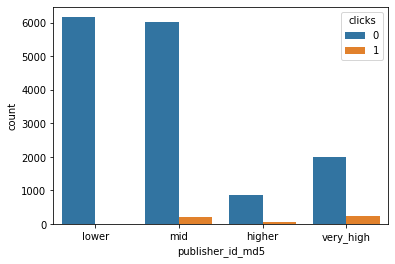

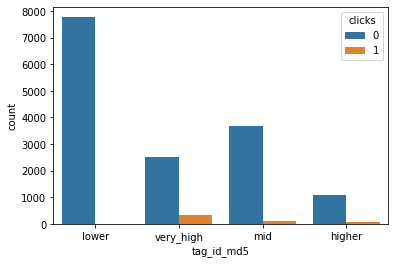

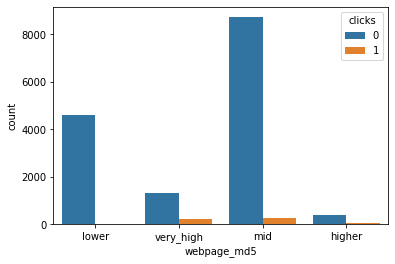

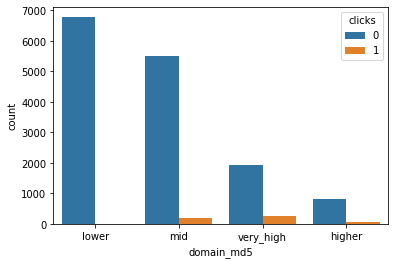

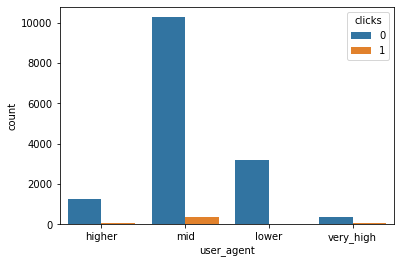

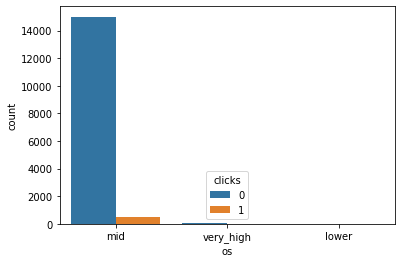

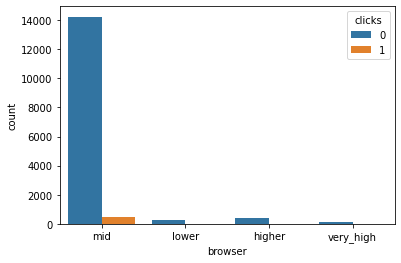

In [52]:
for i in object_features:
    sns.countplot(x = i, hue = "clicks", data = df)
    plt.show()



<font color='blue'>**Conclusion: we can see for example , that type of publisher_id is important for getting high number of clicks. !!.**</font>

**lets see the lables(click) distribution:**

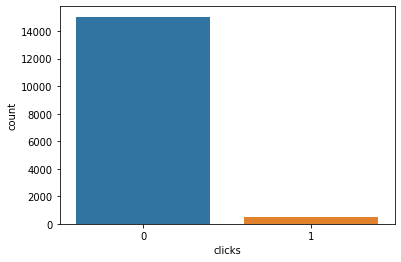

In [53]:
sns.countplot(df[target])

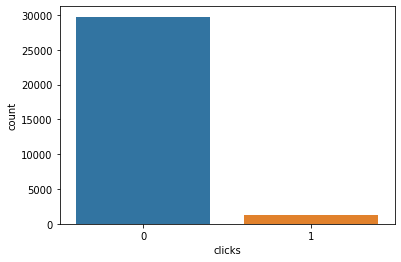

In [54]:
sns.countplot(df_outliers[target])

We can obviously see that out dataset is imbalaned so we need to balance the data - we'll do it using SMOTE which is the most popular way of balancing an imbalanced dataset.

# Correlation matrix

correlation matrix is simply a table which displays the linear relationships between each pair of features (including the target).

In [55]:
df.corr()

,Day of month,hr,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
Day of month,1.000000,-0.048893,-0.112059,0.111831,-0.113902,0.014926,-0.126531,-0.000757,-0.181436,-0.023197
hr,-0.048893,1.000000,0.002074,0.011382,-0.022047,-0.006004,0.001820,-0.000179,0.011313,0.021242
auction_type,-0.112059,0.002074,1.000000,-0.039178,0.138490,-0.302109,0.161541,0.104847,0.053190,0.019252
banner_width,0.111831,0.011382,-0.039178,1.000000,-0.887949,-0.140851,-0.019837,0.052433,-0.044450,-0.012562
banner_height,-0.113902,-0.022047,0.138490,-0.887949,1.000000,0.142101,0.015543,-0.064078,0.038997,0.004330
banner_position,0.014926,-0.006004,-0.302109,-0.140851,0.142101,1.000000,-0.130939,-0.354841,0.034526,-0.003532
ctr,-0.126531,0.001820,0.161541,-0.019837,0.015543,-0.130939,1.000000,0.053981,0.069787,0.058178
viewability,-0.000757,-0.000179,0.104847,0.052433,-0.064078,-0.354841,0.053981,1.000000,-0.053363,0.025123
session_depth,-0.181436,0.011313,0.053190,-0.044450,0.038997,0.034526,0.069787,-0.053363,1.000000,0.025751
clicks,-0.023197,0.021242,0.019252,-0.012562,0.004330,-0.003532,0.058178,0.025123,0.025751,1.000000


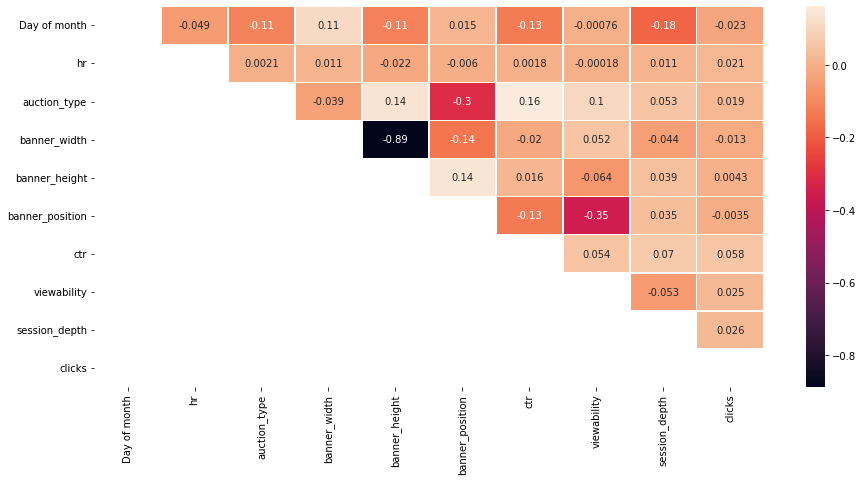

In [56]:
corr = df.corr()
matrix = np.tril(corr)
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr, annot=True, mask=matrix, linewidths=.5);

as we can see, there is a strong relation between viewbility to banner_position.
also between banner_height to banner_width, which is make sense of course.
but its hard to find a direct relation between click and specific feature (this is not final conclusion of course , its just from quick view)
If I had more time, I would see also the corrlation between the object types from the dataset.

#ONE HOT ENCODING

In [57]:
#for purpose of efficiency and because I need to upload the assignment soon, I will exlude publisher_id_md5,tag_id_m5,webpage_md5 
#, domain_md5,user_agent,city. altough as we saw for example, publisher_id is strong feature
df = df.drop(['publisher_id_md5','tag_id_md5','webpage_md5','domain_md5','user_agent','city'], axis=1)
df_outliers = df_outliers.drop(['publisher_id_md5','tag_id_md5','webpage_md5','domain_md5','user_agent','city'], axis=1)

working right now only on outliers dataset


In [58]:
df

,Day of month,hr,os,browser,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,21,2,mid,mid,AZ,2,336,280,1,0.005450,0.61,1.0,0
1,21,1,mid,mid,TX,2,200,200,3,0.001672,0.56,-1.0,0
2,21,1,mid,mid,AZ,1,300,250,3,0.001885,0.71,-1.0,0
3,21,1,mid,mid,NJ,2,728,90,1,0.003074,0.55,-1.0,0
4,21,3,mid,mid,VA,2,336,280,3,0.005167,0.74,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15570,3,16,mid,mid,WI,2,728,90,1,0.000262,0.50,-1.0,0
15571,3,16,mid,mid,FL,2,336,280,1,0.003590,0.72,-1.0,0
15572,3,16,mid,mid,SC,2,336,280,1,0.000781,0.89,-1.0,0
15573,2,21,mid,mid,IL,1,728,90,3,0.002101,0.46,-1.0,0


In [59]:
idx = 0 
df.insert(idx, 'banner_pos', df['banner_position'])
df = df.drop(columns=['banner_position'])

In [60]:
idx = 0 
df_outliers.insert(idx, 'banner_pos', df_outliers['banner_position'])
df_outliers = df_outliers.drop(columns=['banner_position'])

In [61]:
X_outliers = df_outliers.drop(columns=target)
y_outliers = df_outliers[target]

In [62]:
X = df.drop(columns=target)
y = df[target]

In [63]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [64]:
features_to_encode = ['banner_pos','Day of month','hr','os','browser','state','auction_type']

In [65]:
for feature in features_to_encode:
    X = encode_and_bind(X, feature)

In [66]:
for feature in features_to_encode:
    X_outliers = encode_and_bind(X_outliers, feature)

#Normalization

We want to normalize the data because it will give us insights about which features are the most important for the regression, because the bigger the coefficient (weight) the more important the feature.

Without normalization, we would assume by mistake a big importance to a not important feature and a small importance to an important feature.

Also, it doesn't harm the accuracy of the decision tree.

We'll use Standard_scaler which standardizes features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Executing train_test_split in the right timing!

In [67]:
def standard_scaler(X):
  #Set up a standard scaler for the features
  col_names = list(X.columns)
  s_scaler = preprocessing.StandardScaler()
  X_df= s_scaler.fit_transform(X)
  X_df = pd.DataFrame(X_df, columns=col_names)
  return X_df  

In [68]:
scaled_features = X.copy()
col_names =['banner_width','banner_height','ctr','viewability']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X[col_names] = features

In [69]:
print(X)

       banner_width  banner_height       ctr  ...  state_WI  state_WV  state_WY
0         -0.792781       1.115975  0.886795  ...         0         0         0
1         -1.480544       0.230963 -0.317216  ...         0         0         0
2         -0.974836       0.784095 -0.249537  ...         0         0         0
3          1.189596      -0.985929  0.129601  ...         0         0         0
4         -0.792781       1.115975  0.796723  ...         0         0         0
...             ...            ...       ...  ...       ...       ...       ...
15570      1.189596      -0.985929 -0.766815  ...         1         0         0
15571     -0.792781       1.115975  0.294100  ...         0         0         0
15572     -0.792781       1.115975 -0.601361  ...         0         0         0
15573      1.189596      -0.985929 -0.180602  ...         0         0         0
15574      1.189596      -0.985929  1.027497  ...         0         0         0

[15575 rows x 62 columns]


In [70]:
scaled_features = X_outliers.copy()
col_names =['banner_width','banner_height','ctr','viewability']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_outliers[col_names] = features

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [72]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=random_state, stratify=y_outliers)

# SMOTE
Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important and in our case is the number of deads from heart failure.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In this reserach proposal, we will use SMOTE for oversampling imbalanced classification datasets.

explanation has been taken from - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data.

SMOTE first start by choosing random data from the minority class, then k-nearest neighbors from the data are set.

Synthetic data would then made between the random data and the randomly selected k-nearest neighbor.

In [73]:
def oversample_features_target(X, y):
  return SMOTE(random_state=random_state, n_jobs=-1, k_neighbors=5).fit_resample(X, y)

In [74]:
X_train_outliers_smote, y_train_outliers_smote = oversample_features_target(X_train_outliers, y_train_outliers)

In [75]:
X_train_nooutliers_smote , y_train_nooutliers_smote = oversample_features_target(X_train, y_train)

In [76]:
# important lines
X_train_nooutliers_smote = pd.DataFrame(np.matrix(X_train_nooutliers_smote),columns=X.columns)
X_train_outliers_smote = pd.DataFrame(np.matrix(X_train_outliers_smote),columns=X_outliers.columns)

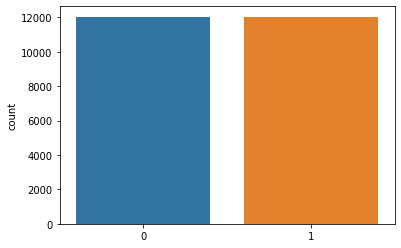

In [77]:
sns.countplot(y_train_nooutliers_smote)

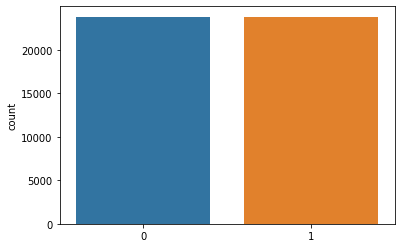

In [78]:
sns.countplot(y_train_outliers_smote)

Now we can see the data is balanced so SMOTE worked!

In [79]:
X_train_nooutliers_smote.head(5)

,banner_width,banner_height,ctr,viewability,session_depth,os_lower,os_mid,os_very_high,browser_higher,browser_lower,browser_mid,browser_very_high,state_AK,state_AL,state_AR,state_AZ,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,-0.125246,-1.317809,0.806075,-0.452790,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.974836,0.784095,-0.816184,-0.350648,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.792781,1.115975,-0.763666,-1.474212,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.792781,1.115975,-0.331950,0.568632,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.792781,1.115975,-0.850235,-1.269928,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#**Feature importance of tree based classifiers**

In order to see the most informative features for the prediction of clicks we displayed the feature importance for the upcoming trees.

[7.28625132e-02 7.17127134e-02 2.18090158e-01 2.31756889e-01
 6.06735760e-02 0.00000000e+00 0.00000000e+00 1.18825065e-03
 8.05246215e-03 5.26384292e-03 9.00829846e-03 1.28249360e-05
 8.11729914e-03 5.73097711e-03 2.63310850e-03 1.29891400e-03
 1.61469164e-02 1.16881418e-02 2.90039241e-03 5.26254278e-03
 3.38952931e-03 1.55229045e-02 8.86199817e-03 6.66578276e-03
 5.99758230e-03 7.69633552e-03 7.91881780e-03 8.61796792e-03
 2.68818508e-03 1.10013393e-02 6.46509933e-03 9.11813349e-03
 6.03099657e-03 2.00934337e-03 1.09015903e-02 1.02520062e-03
 3.98403757e-03 2.81213557e-03 1.20367733e-02 3.68629700e-03
 8.84249568e-03 1.53892437e-02 9.86635511e-03 6.37116796e-03
 4.08505895e-03 8.51414180e-03 2.82735088e-03 6.28288857e-03
 1.15668699e-03 1.04889475e-02 2.09402425e-02 3.83171532e-03
 1.13079555e-02 1.30058124e-03 9.91570903e-03 6.19245729e-03
 2.61569791e-03 1.24143368e-03]


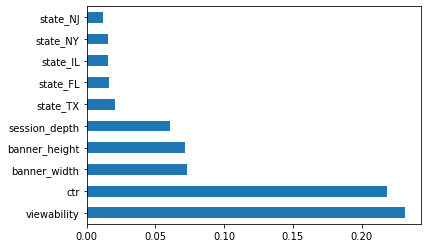

In [80]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train_outliers_smote,y_train_outliers_smote)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_outliers_smote.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[5.97881667e-02 6.27402205e-02 1.61319051e-01 1.63020155e-01
 3.33252905e-02 8.01309925e-05 7.92895446e-04 7.10061357e-04
 9.18386367e-03 7.85341185e-03 1.25609015e-02 6.37557753e-03
 2.09011130e-03 6.88330304e-03 9.74957971e-03 2.21808488e-02
 1.43034453e-02 6.41971214e-03 1.99387388e-03 2.16641230e-03
 2.23333745e-02 1.67216693e-02 4.58943769e-03 5.63341893e-03
 3.20707929e-03 1.81628583e-02 1.40634056e-02 3.55233419e-03
 5.26346030e-03 5.09986589e-03 1.26249925e-02 7.11733065e-03
 3.70993457e-03 1.53226185e-02 8.60234916e-03 8.87765275e-03
 4.18015413e-03 1.31082750e-03 1.86789487e-02 4.64700175e-04
 2.03783130e-03 3.76061170e-03 1.44267028e-02 4.09127313e-03
 6.77387409e-03 3.39970598e-02 2.32536491e-02 1.14591467e-02
 8.55005020e-03 1.55270064e-02 2.20790165e-03 7.38786666e-03
 4.58813365e-04 1.41598557e-02 3.10475165e-02 3.98359350e-03
 2.16464099e-02 3.02658094e-04 1.47052660e-02 1.09774742e-02
 2.62167353e-03 3.57034010e-03]


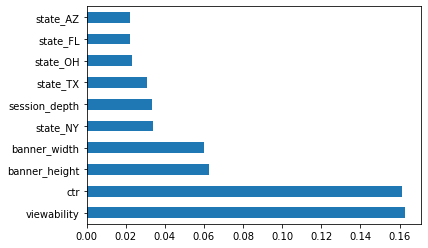

In [81]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train_nooutliers_smote,y_train_nooutliers_smote)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_nooutliers_smote.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


## <font color='blue'>**Conclusion:  According to DecisionTreeClassifier,  the ctr,viewability are most important for predicting click/non-clicks, and then banner size, for both data set,even with outliers and with none !!.**</font>

#Lets run some models!

the right approch for tabular data set is to use Descision Tree Algorithms, as we know , and can be seen here also https://arxiv.org/abs/2106.03253 so I will start with these models first.


###Base Models that has been chosen for the specific problem:
I chose **decision tree algorithms** and **Artifiical Neural Network**, descision trees because it is possible that the data does not necessarily have a linear relationship and therefore a decision tree can map it.


**Decision tree** is a prediction model that provides a mapping between observations and the appropriate values ​​for them,decision tree is a flow chart spring, in which each internal node (not a leaf) indicates a test on a feature, each branch represents a test result, and each leaf node holds a grade label. The highest node in a tree is the root A decision tree can be run so that the split is according to the Entropy Index (IG) or the Gini Index. it is not necessarily linear like logistic regression, we chose to use the Gini index because the entropy range ranges from 0 to 1 and the range of contamination in Gini ranges from 0 to 0.5. From this we can conclude that the impurity in Ginny is better compared to entropy for choosing the best features for splitting a junction

##CAT_classifier

In [82]:
from catboost import CatBoostClassifier

In [83]:
cat_boost= CatBoostClassifier(learning_rate=0.05, loss_function='Logloss', 
                             random_state=123, iterations=100, eval_metric="Logloss")

In [84]:
cat_boost.fit(X_train_outliers_smote, y_train_outliers_smote, eval_set=(X_test_outliers, y_test_outliers), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746122	test: 0.6822361	best: 0.6822361 (0)	total: 77ms	remaining: 7.62s
1:	learn: 0.6586448	test: 0.6715244	best: 0.6715244 (1)	total: 103ms	remaining: 5.06s
2:	learn: 0.6460929	test: 0.6623272	best: 0.6623272 (2)	total: 133ms	remaining: 4.3s
3:	learn: 0.6403183	test: 0.6552491	best: 0.6552491 (3)	total: 156ms	remaining: 3.74s
4:	learn: 0.6345202	test: 0.6478914	best: 0.6478914 (4)	total: 179ms	remaining: 3.4s
5:	learn: 0.6263864	test: 0.6414285	best: 0.6414285 (5)	total: 209ms	remaining: 3.28s
6:	learn: 0.6202525	test: 0.6371414	best: 0.6371414 (6)	total: 233ms	remaining: 3.1s
7:	learn: 0.6162347	test: 0.6321841	best: 0.6321841 (7)	total: 263ms	remaining: 3.03s
8:	learn: 0.6117695	test: 0.6277898	best: 0.6277898 (8)	total: 291ms	remaining: 2.94s
9:	learn: 0.6055808	test: 0.6231578	best: 0.6231578 (9)	total: 316ms	remaining: 2.85s
10:	learn: 0.6024649	test: 0.6189508	best: 0.6189508 (10)	total: 344ms	remaining: 2.79s
11:	learn: 0.5992700	test: 0.6159493	best: 0.6159493 (11

In [85]:
c= cat_boost.get_feature_importance(prettified=True).sort_index(ascending=True)

In [86]:
y_pred_outliers_smote= cat_boost.predict(X_test_outliers, prediction_type="Class", ntree_start=0, ntree_end= cat_boost.get_best_iteration(),thread_count=-1, 
                               verbose=None)

In [87]:
print(accuracy_score(y_pred_outliers_smote,y_test_outliers))

0.8476021886063727


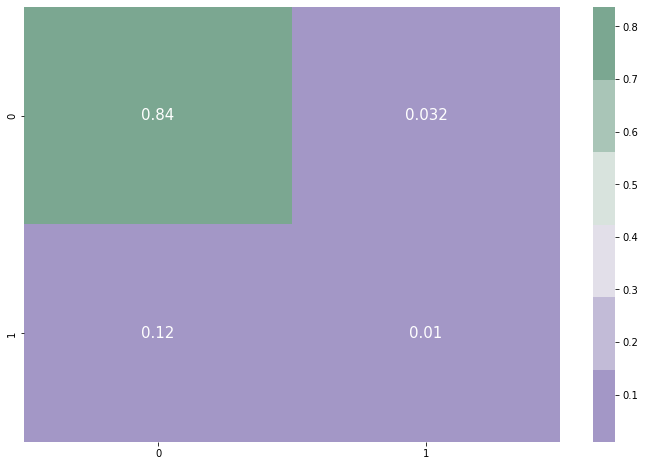

In [88]:
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_pred_outliers_smote, y_test_outliers)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [89]:
cat_boost= CatBoostClassifier(learning_rate=0.05, loss_function='Logloss', 
                             random_state=123, iterations=100, eval_metric="Logloss")

cat_boost.fit(X_train_nooutliers_smote, y_train_nooutliers_smote, eval_set=(X_test, y_test), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6740232	test: 0.6815691	best: 0.6815691 (0)	total: 23.4ms	remaining: 2.32s
1:	learn: 0.6534790	test: 0.6714025	best: 0.6714025 (1)	total: 41.9ms	remaining: 2.05s
2:	learn: 0.6420412	test: 0.6650391	best: 0.6650391 (2)	total: 60.2ms	remaining: 1.94s
3:	learn: 0.6284692	test: 0.6561427	best: 0.6561427 (3)	total: 76.8ms	remaining: 1.84s
4:	learn: 0.6211648	test: 0.6503894	best: 0.6503894 (4)	total: 93.5ms	remaining: 1.78s
5:	learn: 0.6145318	test: 0.6444366	best: 0.6444366 (5)	total: 110ms	remaining: 1.73s
6:	learn: 0.6084146	test: 0.6387508	best: 0.6387508 (6)	total: 127ms	remaining: 1.68s
7:	learn: 0.5987702	test: 0.6316557	best: 0.6316557 (7)	total: 148ms	remaining: 1.7s
8:	learn: 0.5897399	test: 0.6248168	best: 0.6248168 (8)	total: 165ms	remaining: 1.67s
9:	learn: 0.5780078	test: 0.6170118	best: 0.6170118 (9)	total: 187ms	remaining: 1.69s
10:	learn: 0.5709949	test: 0.6111205	best: 0.6111205 (10)	total: 205ms	remaining: 1.66s
11:	learn: 0.5632964	test: 0.6053630	best: 0.605

In [90]:
y_pred_nooutliers_smote= cat_boost.predict(X_test, prediction_type="Class", ntree_start=0, ntree_end= cat_boost.get_best_iteration(),thread_count=-1, 
                               verbose=None)

In [91]:
print(accuracy_score(y_pred_nooutliers_smote,y_test))

0.9386837881219904


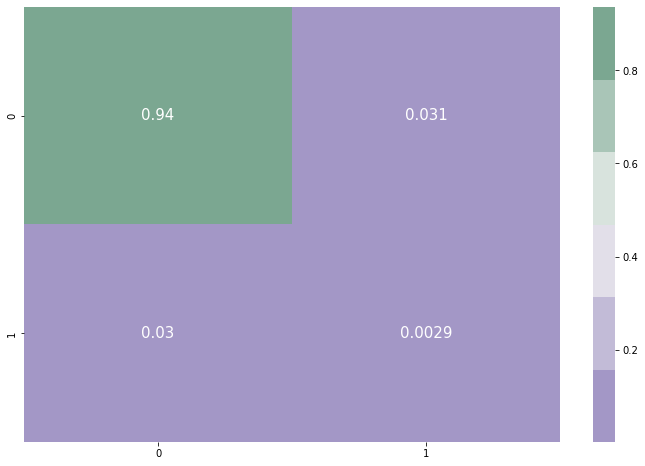

In [92]:
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_pred_nooutliers_smote, y_test)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})


## <font color='red'>**Conclusion:  According to the model,it is better to remove outliers**</font>

RANDOM FOREST

In [93]:
def print_accuracy_RF(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy:", accuracy_score(y_pred, y_test))

In [94]:
print_accuracy_RF(X_train_nooutliers_smote, y_train_nooutliers_smote, X_test, y_test)

Accuracy: 0.9386837881219904


In [95]:
print_accuracy_RF(X_train_outliers_smote, y_train_outliers_smote, X_test_outliers, y_test_outliers)

Accuracy: 0.8962021242355971



## <font color='red'>**Conclusion:  According to random forest, is better to remove outliers**</font>

of course we under same random_state variable, so we need to take that into considiration

#XGBOOST Algorithm

In [96]:
from xgboost import XGBClassifier
model = XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, n_estimators=500, max_depth=11)
model.fit(X_train_nooutliers_smote,y_train_nooutliers_smote)
y_pred_nooutliers_smote = model.predict(X_test)

[17:52:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


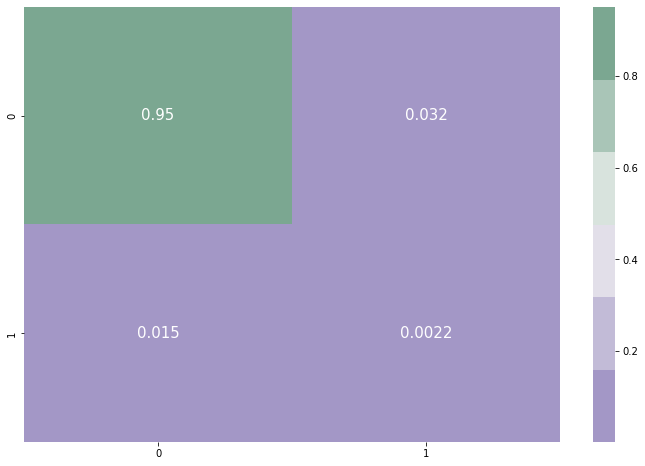

In [97]:
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_pred_nooutliers_smote, y_test)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [98]:
print(accuracy_score(y_pred_nooutliers_smote,y_test))


0.9531300160513644


In [99]:
print(classification_report(y_pred_nooutliers_smote,y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3061
           1       0.07      0.13      0.09        54

    accuracy                           0.95      3115
   macro avg       0.53      0.55      0.53      3115
weighted avg       0.97      0.95      0.96      3115



lets view AUC-ROC score

In [100]:
roc_auc_score(y_test, y_pred_nooutliers_smote)

0.5252089643020624

Lets run XGBclassifier on outliers dataset

In [101]:
from xgboost import XGBClassifier
model = XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, n_estimators=500, max_depth=11)
model.fit(X_train_outliers_smote,y_train_outliers_smote)
y_pred_outliers_smote = model.predict(X_test_outliers)

[17:52:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [102]:
print(accuracy_score(y_pred_outliers_smote,y_test_outliers))


0.9419053749597682


In [103]:
print(classification_report(y_pred_outliers_smote,y_test_outliers))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6100
           1       0.03      0.07      0.04       114

    accuracy                           0.94      6214
   macro avg       0.51      0.51      0.51      6214
weighted avg       0.96      0.94      0.95      6214



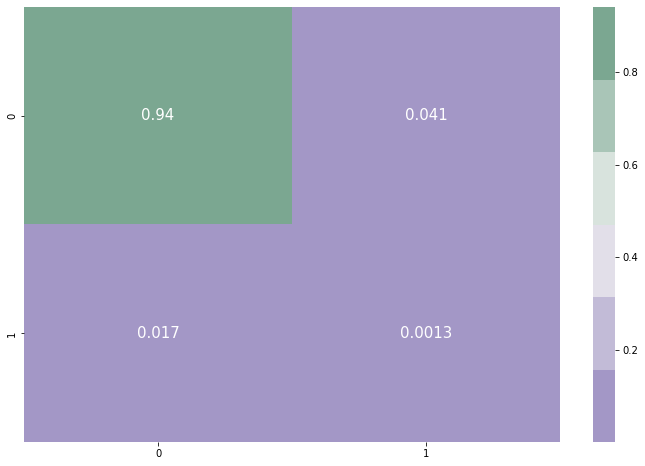

In [104]:
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_pred_outliers_smote, y_test_outliers)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

lets view ROC_AUC score:

In [105]:
roc_auc_score(y_test_outliers, y_pred_outliers_smote)

0.5063030592679251

## <font color='red'>**Conclusion: According to XGBOOST,we also discovered that outliers for the specific problem, are bad for the models.**</font>

###altought the right approch for tabular data set is to use Descision Tree but I will use also Artificial Neural Network as another approach.

##Artificial Neural Network
how we build the model:

Initialising the ANN
Defining by adding layers
Compiling the ANN
Train the ANN

In [106]:
import tensorflow 
def generic_ANN( X,y,input_dim,min_delta=0,patience=10, learning_rate = 0.01):
  early_stopping = callbacks.EarlyStopping(
      min_delta=min_delta,
      patience=patience,
      restore_best_weights=True)

  # Initialising the NN
  model = Sequential()
  optimizer = tensorflow.keras.optimizers.Adam(lr=learning_rate)
  # layers
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_dim))
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Compiling the ANN
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Train the ANN

  history = model.fit(X, y, batch_size = 32, verbose = 1, epochs = 100,callbacks=[early_stopping], validation_split=0.2) 
  return history , model 

Full run of AAN only on the data set with out the outliers

In [107]:
history_nooutliers_smote ,model_nooutliers_smote= generic_ANN(X_train_nooutliers_smote,y_train_nooutliers_smote,62,0.005)

Epoch 1/100
602/602 [==============================] - 4s 5ms/step - loss: 0.6340 - accuracy: 0.6249 - val_loss: 0.9506 - val_accuracy: 0.0000e+00
Epoch 2/100
602/602 [==============================] - 3s 4ms/step - loss: 0.5902 - accuracy: 0.6237 - val_loss: 0.8751 - val_accuracy: 0.0000e+00
Epoch 3/100
602/602 [==============================] - 3s 4ms/step - loss: 0.5675 - accuracy: 0.6401 - val_loss: 0.8137 - val_accuracy: 0.0000e+00
Epoch 4/100
602/602 [==============================] - 3s 4ms/step - loss: 0.5420 - accuracy: 0.6734 - val_loss: 0.7363 - val_accuracy: 0.8185
Epoch 5/100
602/602 [==============================] - 2s 4ms/step - loss: 0.5264 - accuracy: 0.6959 - val_loss: 0.6991 - val_accuracy: 0.8854
Epoch 6/100
602/602 [==============================] - 3s 4ms/step - loss: 0.5191 - accuracy: 0.7110 - val_loss: 0.6523 - val_accuracy: 0.9016
Epoch 7/100
602/602 [==============================] - 3s 4ms/step - loss: 0.5019 - accuracy: 0.7208 - val_loss: 0.7080 - val_accu

In [108]:
def print_val_accuracy(history,type_of_data):
  val_accuracy = np.mean(history.history['val_accuracy'])
  print("\n%s: %.2f%%" % ('val_accuracy on ' + type_of_data+'', val_accuracy*100))

In [109]:
print_val_accuracy(history_nooutliers_smote,'nooutliersXsmote')


val_accuracy on nooutliersXsmote: 85.01%


Plotting training and validation loss over epochs

In [110]:
def print_loss(history,type_of_data):
  history = pd.DataFrame(history.history)

  plt.plot(history.loc[:, ['loss']], "#6daa9f", label='Training loss')
  plt.plot(history.loc[:, ['val_loss']],"#774571", label='Validation loss')
  plt.title('Training and Validation loss on'+' '+type_of_data+' dataset')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc="best")

  plt.show()

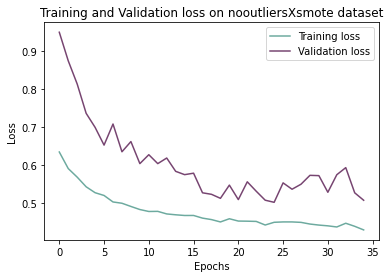

In [111]:
print_loss(history_nooutliers_smote,'nooutliersXsmote')

Plotting training and validation accuracy over epochs

In [112]:
def plot_accuracy(history,type_of_data):
  history = pd.DataFrame(history.history)

  plt.plot(history.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
  plt.plot(history.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

  plt.title('Training and Validation accuracy on '+ type_of_data)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

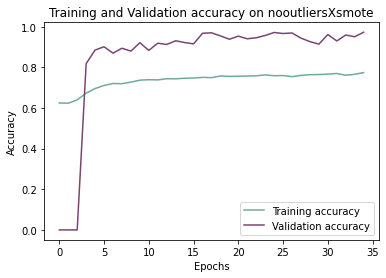

In [113]:
plot_accuracy(history_nooutliers_smote,'nooutliersXsmote')

In [114]:
def print_confusion_matrix_and_accuracy_score(model,X_test,y_test,type_of_data):
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5)
  np.set_printoptions()
  print('accuracy score on '+type_of_data+ ' is ' + str(accuracy_score(y_test,y_pred)))
  # confusion matrix
  cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
  plt.subplots(figsize=(12,8))
  cf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

accuracy score on nooutliersXsmote is 0.614446227929374


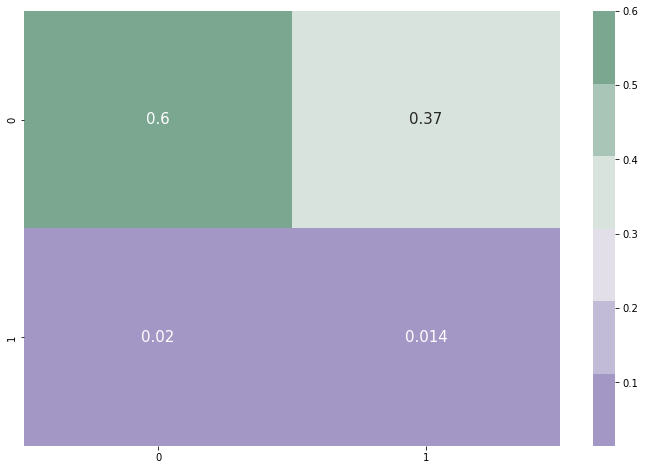

In [115]:
print_confusion_matrix_and_accuracy_score(model_nooutliers_smote,X_test,y_test,'nooutliersXsmote')

Not great result with ANN, if I had more time I would made grid search for searching best hyper parameters.

#AutoML

TPOT is an AutoML library in python that optimizes ML pipelines using genetic programming.

Genetic Programming is an automatic programming technique that favors the evolution of computer programs that solve (or approximately solve) problems.

TPOT would also search for the best (accuracy wise) hyperparameters for us.

In [116]:
def run_tpot(X_train, y_train):
  tpot = TPOTClassifier(generations=None,
                      random_state=random_state, 
                      max_time_mins=60,
                      n_jobs=-1)
  tpot.fit(X_train, y_train)
  print(tpot.score(X_test, y_test))
  return tpot


The above method would run for 1 hour to find the best (accuracy wise) pipeline.

I ran this method for the dataset without the outliers, because I get a strong indication from the earlier algorithms that no outliers dataset perform best.

The result is in the following cells.



In [117]:
#tpot_nooutliers_smote = run_tpot(X_train_nooutliers_smote, y_train_nooutliers_smote)

In [118]:
#tpot_nooutliers_smote.export('tpot_exported_pipeline.py')

In [119]:
#print(tpot_nooutliers_smote.score(X_test, y_test))

result on test is 96.6% (for accuracy of course)

The pipe line that we recieve from Tipot after one hour of training is:

In [120]:
"""
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.9666010912270847
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=MLPClassifier(alpha=0.1, learning_rate_init=0.5)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.05, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
"""

'\nimport numpy as np\nimport pandas as pd\nfrom sklearn.ensemble import ExtraTreesClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.pipeline import make_pipeline, make_union\nfrom tpot.builtins import StackingEstimator\nfrom tpot.export_utils import set_param_recursive\n\n# NOTE: Make sure that the outcome column is labeled \'target\' in the data file\ntpot_data = pd.read_csv(\'PATH/TO/DATA/FILE\', sep=\'COLUMN_SEPARATOR\', dtype=np.float64)\nfeatures = tpot_data.drop(\'target\', axis=1)\ntraining_features, testing_features, training_target, testing_target =             train_test_split(features, tpot_data[\'target\'], random_state=42)\n\n# Average CV score on the training set was: 0.9666010912270847\nexported_pipeline = make_pipeline(\n    StackingEstimator(estimator=MLPClassifier(alpha=0.1, learning_rate_init=0.5)),\n    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.05, min_sam

**lets run it!**

In [121]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

training_features, testing_features, training_target, testing_target = X_train_nooutliers_smote, X_test, y_train_nooutliers_smote , y_test
# Average CV score on the training set was: 0.976322779570317
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=MLPClassifier(alpha=0.1, learning_rate_init=0.5)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.05, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
)
exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [122]:
print(accuracy_score(results,y_test))

0.936115569823435


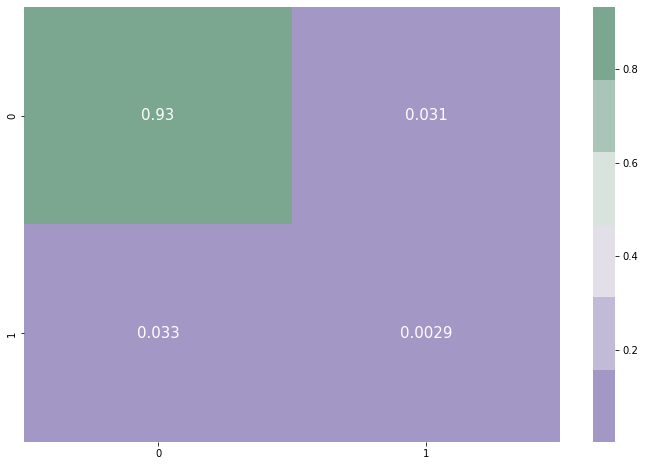

In [123]:
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(results, y_test)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [124]:
roc_auc_score(y_test, results)

0.5255036776463063

we can see that AutoML via cross validation out performed every manual algorithm ,with roc_auc score of 0.52

#Some conclusions:


* Regarding oversampling the data, according to all of our experiments, in general, SMOTE improved the accuracy (sometimes significantlly), or didn't harm it.

* Regarding outliers, according to all of our experiments, it's much better to run the model without the outliers than with them.


* the right approch for tabular data set is to use Descision Tree Algorithms, as 
we know , and can be seen here also https://arxiv.org/abs/2106.03253 but I used also Artificial Neural Network as another approach for comparison.


*   According to roc_auc_score, which isn't high score(just 51%), seems like predicting 
clicks via unblanced data , with very little positive cases, is not an easy problem.
(accuracy score, cant teach us much about our models,because it is unbalanced data problem, but it can teach us sometimes what are the strongest features to predict non clicks)



*   instead of one-hot encodding time (like hour or day) I could bin them thorugh week and *am/pm* for example. I thought about that, but wasn't enough time for that, this way I could predict click, per day in a week and so on.



more conclusions can be found above. 
